## 1. Environment Setup

In [1]:
import tweepy
from tweepy import OAuthHandler
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import re
import operator
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from operator import itemgetter

In [2]:
import nltk
#nltk.download('stopwords')  # If stopwords has not been downloaded

## 2. Data Acquisition

In [3]:
punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
stop_words = set(stopwords.words('english'))
s="ipl"

consumer_key = 'aTdTTqgBrfk5vfCqqItxGoByi'
consumer_secret = 'obHwzoYVGIOq7o3nD7r1ULouQZ27xgIlmzKSMEocx0UQ91m8iY'
access_token = '2943673172-brbBP1WgHciMM85Qq3cBCgJBaOEIdMSzxUfyKdQ'
access_token_secret = 'rMb4Lf0DWglxljacePbUUnbHrvp6kI4l4ZEV1qbob1r3b'
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)


## 3. Data Preprocessing

## 4. Text Mining

In [4]:
n=0
clean_words = []
lower_words=[]
word_count={}
word_count_n={}
for tweet in tweepy.Cursor(api.search, q=s, lang="en").items(100):
    n=n+1
    #print(tweet.text)
    words = tweet.text.split()
    for u in words:
        lower_words.append( u.lower())

    for w in lower_words:
        if w not in stop_words and  w not in punctuations:
            clean_words.append(w)

    for cw in clean_words:
        #print(cw)
        if cw not in word_count:
            word_count[cw]=1
        else:
            word_count[cw]=word_count[cw]+1
    for cwt in word_count:
        if word_count[cwt]>50:
            word_count_n[cwt]=word_count[cwt]

## 5. Data visualization

In [5]:
#print(clean_words)

In [6]:
#print(word_count_n.keys())

In [7]:
clean_tweets=list(word_count_n.keys())

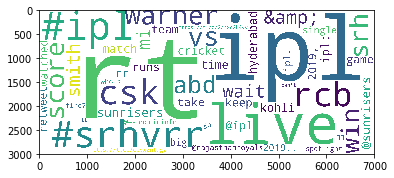

In [8]:
from wordcloud import WordCloud
#from PIL import Image
#import matplotlib.pyplot as plt

wc = WordCloud(background_color="white",width=7000,height=3000, max_words=50,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(word_count_n)
plt.imshow(wc)

## 6. Clustering Analysis

In [9]:
# Load GloVe's embeddings
embeddings_index = {}
with open('/Users/George Thomas/Documents/Kevin_Python/Twitter_Clustering/glove.twitter.27B/glove.twitter.27B.200d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings:', len(embeddings_index))

Word embeddings: 1193514


In [10]:
# Create an 'average' embedding for each tweet

embedding_dim = 200 # Use 200 to match GloVe's embedding size

embed_tweets = [] # Contains the 'average' embedding for each tweet
total_embeds = 0 
null_embeds = 0 

for tweet in clean_tweets:
    avg_embed = np.zeros(embedding_dim) # Set default embedding for each tweet
    for word in tweet.split():
        total_embeds += 1
        embed = embeddings_index.get(word)
        if embed is not None:
            avg_embed += embed # Add embedding's values to vectors
        else:
            null_embeds += 1
    embed_tweets.append(avg_embed/len(tweet.split()))

print("Total Number of Embeddings:", total_embeds)
print("Number of Null Embeddings:", null_embeds)
print("% of Embeddings that are Null: {}%".format(round(null_embeds/total_embeds,4)*100))

Total Number of Embeddings: 727
Number of Null Embeddings: 381
% of Embeddings that are Null: 52.410000000000004%


In [11]:
# Reduce the dimensions of each tweet to 1
pca = PCA(n_components=1, random_state = 2)
pca_tweets = pca.fit_transform(embed_tweets)

In [12]:
# Order the tweets based on their PCA values, from low to high
# Similar tweets will be closer together
pca_tweets_list = [] # Contains the pca values
for tweet in pca_tweets:
    pca_tweets_list.append(tweet[0])

order = np.array(pca_tweets_list).argsort()
pca_labels = order.argsort()
pca_labels *= 2 # Multiple the labels by 2 so generated tweets can have odd values and 
                # Even values will represent tweets that were used for training

In [13]:
# Inspect pca_labels
pca_labels[:10]

array([ 828, 1164,  858,  886,  812, 1180,  544, 1048,  540,  822],
      dtype=int64)

In [14]:

# Group tweets by similarity
kmeans = KMeans(n_clusters=5, max_iter = 1000, n_init = 20, random_state=2).fit(pca_tweets)
labels = kmeans.labels_

In [15]:
# The number of tweets in each group.
pd.DataFrame(labels)[0].value_counts()

0    426
4     77
3     76
2     74
1     74
Name: 0, dtype: int64

In [17]:
def top_n_words(group, n_words):
    '''Find the n most common words in each group'''
    vocab = {} # Create the vocabulary for each group
    for i in range(len(clean_tweets)):
        if labels[i] == group:
            for word in clean_tweets[i].split():
                if word not in vocab:
                    vocab[word] = 1
                else:
                    vocab[word] += 1
      
    # Sort the vocab from most to least common words
    sorted_vocab = sorted(vocab.items(), key=operator.itemgetter(1), reverse=True)
    top_n_words = []
    for word, value in sorted_vocab:
        top_n_words.append(word)
        if len(top_n_words) == n_words:
            break
    print(top_n_words)

In [18]:
# The most common words in each group
groups = len(np.unique(labels))
for i in range(groups):
    print("Group #",i+1)
    top_n_words(i, 10)

Group # 1
['srh', 'head-to-head', '@sunrisers', '@rajasthanroyals', 'evenly', 'leadi…', 'https://t.co/nqduxodeug', '@bizasia:', '#bizasiaratings', '5']
Group # 2
['rt', 'battle', 'top', 'shows', 'uk', 'wednesday', 'five', 'happen', 'teams', 'face']
Group # 3
['rcb', 'csk', 'matched', 'kohli', 'emerge', 'ipl', 'raina', 'dhoni', 'abd', 'slams']
Group # 4
['years', 'last', 'time', 'team', 'live', 'keep', 'call', 'win', 'got', 'wait']
Group # 5
['&amp;', 'mi', 'highest', 'smith', 'cricket', 'winners', 'vs', 'pakistan', 'coz', 'doctor']


In [19]:
# The most common words for all of Trump's tweets
n_words = 100
sorted_vocab = sorted(word_count_n.items(), key=operator.itemgetter(1), reverse=True)
top_n_words = []
for word, value in sorted_vocab:
    if word not in stop_words:
        top_n_words.append(word)
    if len(top_n_words) == n_words:
        break
print("Trump's {} most popular tweeted words (not including stop words):".format(n_words))
print(top_n_words)

Trump's 100 most popular tweeted words (not including stop words):
['rt', 'ipl', 'live', '#ipl', '#srhvrr', 'csk', 'rcb', 'warner', 'vs', 'score', 'srh', 'win', 'abd', '&amp;', 'smith', 'mi', 'wait', 'sunrisers', '@sunrisers', 'ipl:', 'rr', 'kohli', 'match', 'time', 'hyderabad', 'take', 'team', 'game', 'keep', 'runs', 'cricket', '@ipl', '2019,', 'retweet', 'watched', 'single', '2019..', 'ipl.', 'big', '@rajasthanroyals', '@espncricinfo:', 'spotlight', '👀', "who's", 'got', 'fire?', 'https://t.co/cbvx2ntagz', 'https://t.co/2bhxc2k4yv', '😍', "can't", 'kxip', 'last', '#vivoipl', 'would', 'u', 'playing', '@ippatel:', '2014', 'organised', 'outside', 'bharat', 'hm', 'shinde', 'denied', 'provide', 'security', 'due', 'election.', 'loss', 'govt', 'ta…', 'free', 'see', '#ipl2019', '@sshubho:', 'long', 'ipl?', '#kohli:', 'https://t.co/kjgedr5lqh', 'teams', 'face', '@katamulgi:', 'need', '@sirjadeja:', 'winning', 'raina', 'vivo', '2', 'head-to-head', 'battle', 'evenly', 'matched', 'years', 'leadi…'

In [20]:
def print_tweet_group(group, n_tweets):
    '''Prints the first n_tweets in a group'''
    count = 1
    for i in range(len(clean_tweets)):
        if labels[i] == group:
            print("#{}: {}".format(count, clean_tweets[i]))
            count += 1
            if count == n_tweets+1:
                break

In [21]:

# Print the first few tweets in each group
n_tweets = 5
for i in range(groups):
    print("Group #",i+1)
    print_tweet_group(i,n_tweets)
    print()

Group # 1
#1: srh
#2: head-to-head
#3: @sunrisers
#4: @rajasthanroyals
#5: evenly

Group # 2
#1: rt
#2: battle
#3: top
#4: shows
#5: uk

Group # 3
#1: rcb
#2: csk
#3: matched
#4: kohli
#5: emerge

Group # 4
#1: years
#2: last
#3: time
#4: team
#5: live

Group # 5
#1: &amp;
#2: mi
#3: highest
#4: smith
#5: cricket



In [22]:
# Visualize the tweets with TSNE
model = TSNE(n_components=2, random_state=2)
TSNE_tweets = model.fit_transform(embed_tweets)

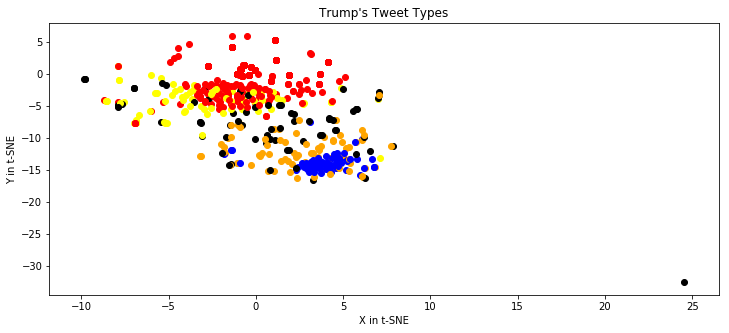

In [23]:
# Build a scatter plot to visualize the tweets.
color_map = {0:'red', 1:'orange', 2:'yellow', 3:'blue', 4:'black'}
plt.figure(figsize=(12,5))

for i in range(len(TSNE_tweets)):
    plt.scatter(x = TSNE_tweets[i][0], 
                y = TSNE_tweets[i][1],
                c = color_map[labels[i]])
plt.xlabel('X in t-SNE')
plt.ylabel('Y in t-SNE')
plt.title('Trump\'s Tweet Types')

offset = 2
x_min = min(TSNE_tweets, key=itemgetter(0))[0] - offset
x_max = max(TSNE_tweets, key=itemgetter(0))[0] + offset
y_min = min(TSNE_tweets, key=itemgetter(1))[1] - offset
y_max = max(TSNE_tweets, key=itemgetter(1))[1] + offset

axes = plt.gca()
axes.set_xlim([x_min,x_max])
axes.set_ylim([y_min,y_max])
plt.show()

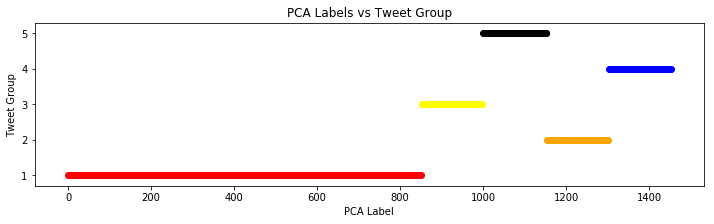

In [24]:

# Create a scatterplot to visualize the tweet groups by the PCA labels
plt.figure(figsize=(12,3))
for i in range(len(TSNE_tweets)):
    plt.scatter(x = pca_labels[i], 
                y = labels[i]+1,
                c = color_map[labels[i]])
    
plt.xlabel('PCA Label')
plt.ylabel('Tweet Group')
plt.title('PCA Labels vs Tweet Group')
    
plt.show()